# Binary classification from 2 features using TensorFlow


Based on the same data model as in the [binary classification](ClassificationContinuous2Features.html) notebook.

The classification is on a single boundary defined by a continuous function and added white noise.

In [1]:
import tensorflow as tf
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
import scikitplot as skplt
import pandas

## Model

Quadratic function as a boundary between positive and negative values

Adding some unknown as a Gaussian noise

The values of X are uniformly distributed and independent

In [2]:
# Two features, Gaussian noise
nFeatures = 2
def generateBatch(N):
    #
    xMin = 0
    xMax = 1
    b = 0.1
    std = 0.1
    #
    x = random.uniform(xMin, xMax, (N, nFeatures))
    # 4th degree relation to shape the boundary
    boundary = 2*(x[:,0]**4 + (x[:,0]-0.3)**3 + b)
    # Adding some gaussian noise
    labels = boundary + random.normal(0, std, N) > x[:,1]
    return (x, labels)

### Training data

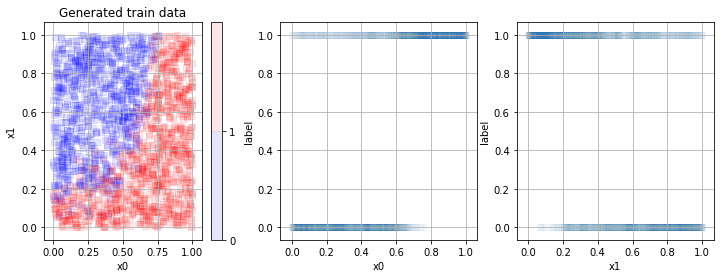

In [3]:
N = 2000
# x has 1 dim in R, label has 1 dim in B
xTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTrain[:,0], xTrain[:,1], c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Generated train data')
plt.grid()
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1])
plt.subplot(1,3,2)
plt.scatter(xTrain[:,0], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x0')
plt.ylabel('label')
plt.grid()
plt.subplot(1,3,3)
plt.scatter(xTrain[:,1], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x1')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.527


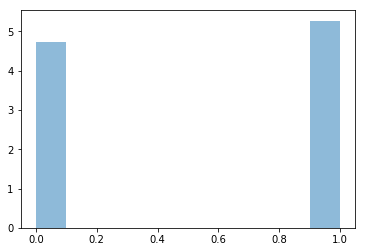

In [4]:
count, bins, ignored = plt.hist(labelTrain, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

### Test data for verification of the model

In [5]:
xTest, labelTest = generateBatch(N)
testColors = ['navy', 'orangered']

# Using TensorFlow

Reference:
- Inspired from https://www.geeksforgeeks.org/ml-logistic-regression-using-tensorflow/ BUT 
    - This example is mixing symbols and values. 
    - For example redefining several times the cost, prediction and accuracy
    - It is actualy quite inefficient
    - There is no verification of the model through a test sample
    - Modifications were also necessary to remove 1 dimension in the features/predictors

In [6]:
# Labels as float {0,1}
labelTrainF = np.multiply(labelTrain, 1.0)
labelTrainF.dtype

dtype('float64')

In [7]:
# Batch size, learning rate, epochs
nBatch = 1000
alpha = 0.05
nEpoch = 10000
# x and y are placeholders for our training data
X = tf.placeholder("float64", [None, nFeatures], name='X')
Y = tf.placeholder("float64", [None, 1], name='Y')
# Initial weights and intercept
Wtf = tf.Variable(tf.zeros((nFeatures, 1), tf.float64), name='W')
Btf = tf.Variable(tf.ones(1, tf.float64), name='b')
# Our model of y = sigmoid(a*x + b)
Y_model = tf.sigmoid(tf.matmul(X, Wtf) + Btf)
# Sigmoid Cross Entropy Cost Function 
Cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_model, labels = Y) 
# Prediction & Accuracy
CorrectPrediction = tf.equal(tf.greater(Y_model, 0.5), tf.greater(Y, 0.5))
Accuracy = tf.reduce_mean(tf.cast(CorrectPrediction, tf.float64))
  
# Gradient Descent Optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate = alpha).minimize(Cost) 

# Global Variables Initializer 
init = tf.global_variables_initializer() 

In [8]:
# Initializing the session and model 
sess = tf.Session() 
sess.run(init) 

# List storing the evolution through epochs 
histo = []

# Iterating through all the epochs 
for epoch in range(nEpoch+1): 

    # Running the Optimizer 
    # Calculating cost, accuracy on current Epoch 
    xBatch, labelBatch = generateBatch(nBatch)
    labelBatchF = np.multiply(labelBatch, 1.0)
    _, c, b, w, accu = sess.run([optimizer, Cost, Btf, Wtf, Accuracy], feed_dict={X: xBatch, Y: labelBatchF.reshape(-1,1)}) 
                                # feed_dict = {X : xTrain, Y : labelTrainF}) 

    # Save history 
    histo.append([np.sum(c), accu, b, w[0], w[1]])

    # Displaying result on current Epoch 
    if epoch % 1000 == 0 and epoch != 0: 
       hNow = histo[-1]
       print("Epoch", epoch, " Cost:", hNow[0], " Accuracy:", hNow[1], "b:", hNow[2], "W:", hNow[3], ',', hNow[4]) 

# Save history as a Panda Data Frame
df = pandas.DataFrame(histo, columns = ('cost', 'accuracy', 'b', 'w0', 'w1'))

Epoch 1000  Cost: 547.222789023  Accuracy: 0.893 b: [-4.90271102] W: [ 18.90841787] , [-11.16076819]
Epoch 2000  Cost: 551.344875013  Accuracy: 0.889 b: [-7.38677746] W: [ 27.02458317] , [-15.41340054]
Epoch 3000  Cost: 551.67264652  Accuracy: 0.901 b: [-9.58095838] W: [ 33.5574305] , [-18.78316043]
Epoch 4000  Cost: 546.419458506  Accuracy: 0.908 b: [-11.47469575] W: [ 39.51215042] , [-21.53120618]
Epoch 5000  Cost: 543.018479606  Accuracy: 0.907 b: [-13.12232348] W: [ 44.70084393] , [-23.80720905]
Epoch 6000  Cost: 547.826061207  Accuracy: 0.895 b: [-14.36875276] W: [ 49.15839676] , [-26.28226104]
Epoch 7000  Cost: 544.431120419  Accuracy: 0.911 b: [-16.00203214] W: [ 53.10117129] , [-27.70459747]
Epoch 8000  Cost: 546.938468517  Accuracy: 0.892 b: [-16.75864854] W: [ 56.32491033] , [-30.00598618]
Epoch 9000  Cost: 530.770529925  Accuracy: 0.908 b: [-17.83051111] W: [ 59.35899046] , [-31.24145527]
Epoch 10000  Cost: 553.718912661  Accuracy: 0.88 b: [-18.99384414] W: [ 62.04468066] , 

In [9]:
bEst = df['b'][len(df['b'])-1]
wEst = np.array([df['w0'][len(df['w0'])-1], df['w1'][len(df['w1'])-1]]).reshape(-1)
print('Estimated b=', bEst, ', w=', wEst)

Estimated b= [-18.99384414] , w= [ 62.04468066 -32.30500027]


The accuracy is quickly reaching a good level. 

However, the gradient is not reaching 0 and the solution is not unique, the coefficients are still evolving with epochs

Text(0.5, 1.0, 'Accuracy')

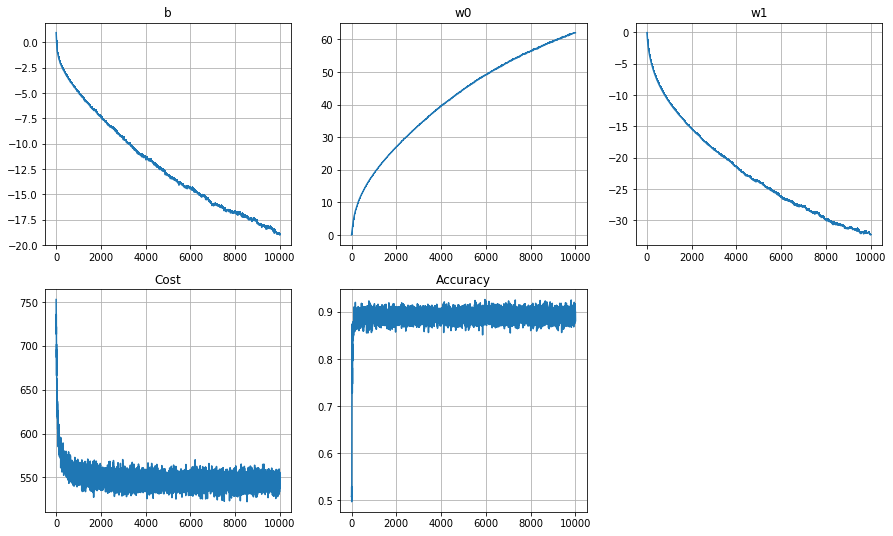

In [10]:
plt.figure(figsize=(15,9))
plt.subplot(2,3,1)
plt.plot(df['b'], marker=',');
plt.title('b')
plt.grid()
plt.subplot(2,3,2)
plt.plot(df['w0'], marker=',');
plt.title('w0')
plt.grid()
plt.subplot(2,3,3)
plt.plot(df['w1'], marker=',');
plt.title('w1')
plt.grid()
plt.subplot(2,3,4)
plt.plot(df['cost'])
plt.grid()
plt.title('Cost')
plt.subplot(2,3,5)
plt.plot(df['accuracy'])
plt.grid()
plt.title('Accuracy')

## Testing the model

In [11]:
yEst = sess.run(Y_model, feed_dict ={X: xTest, Y: np.multiply(labelTest, 1.0).reshape(-1,1)}) 
sess.close()

In [12]:
labelEst = (yEst > 0.5).reshape(-1)

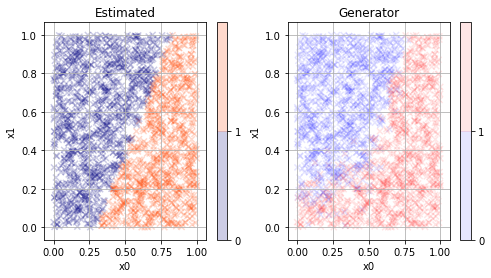

In [13]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], xTest[:,1], c=labelEst, cmap=pltcolors.ListedColormap(testColors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Estimated')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(testColors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);
plt.subplot(1,2,2)
plt.scatter(xTest[:,0], xTest[:,1], c=labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.1);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Generator')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);

Bernouilli parameter = 0.424


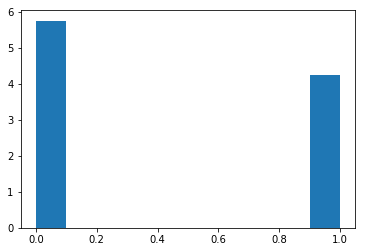

In [14]:
plt.hist(labelEst, 10, density=True)
print('Bernouilli parameter =', np.mean(labelEst))

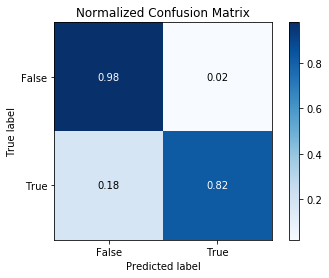

In [15]:
skplt.metrics.plot_confusion_matrix(labelTest, labelEst, normalize=True);

In [16]:
print(skMetrics.classification_report(labelTest, labelEst))

              precision    recall  f1-score   support

       False       0.84      0.98      0.90       989
        True       0.97      0.82      0.89      1011

    accuracy                           0.89      2000
   macro avg       0.90      0.90      0.89      2000
weighted avg       0.91      0.89      0.89      2000



# Where to go from here ?

__Other linear implementations and simple neural nets__ [using "raw" Python or SciKit Learn](ClassificationContinuous2Features.html) ([Notebook](ClassificationContinuous2Features.ipynb)), [using Keras](ClassificationContinuous2Features-Keras.html) ([Notebook](ClassificationContinuous2Features-Keras.ipynb)) up to a simple neural net to achieve better fit, or the [__K Nearest Neighbors classifier__](ClassificationContinuous2Features-KNN.html) ([Notebook](ClassificationContinuous2Features-KNN.ipynb))

__More complex multi-class models__ on the Czech and Norways flags [using Keras](ClassificationMulti2Features-Keras.html) ([Notebook](ClassificationMulti2Features-Keras.ipynb)), showing one of the main motivations to neural networks.

__Compare with the two feature linear regression__ [using simple algorithms](../linear/LinearRegressionBivariate.html) ([Notebook](LinearRegressionBivariate.ipynb])), [or using Keras](LinearRegressionBivariate-Keras.html) ([Notebook](LinearRegressionUnivariate-Keras.ipynb))